I create my dataset to  understand if LSTM will really capture the difference. Below are utility methods. I will generate 5 years of temperature data. Will simulate high global warming. Intention is even if temperature changes dramatically ,will LSTM be able to capture trend.
For making things more difficult I will predict 4 years of data with only 1 year of data.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.core.common import flatten


def gen_normal_data(nums,mean,std):
  s = np.random.normal(mean, std, nums)
  s = [int(k) for k in s]
  return s

def plot_normal_scatter(s):
  y = [i for i in range(len(s))]
  print(s)
  plt.scatter(y,s)
  plt.show()

def plot_hist(s,mean,std):
  count, bins, ignored = plt.hist(s, 30, density=True)
  plt.plot(bins, 1/(std * np.sqrt(2 * np.pi)) *
                np.exp( - (bins - mean)**2 / (2 * std**2) ),
          linewidth=2, color='r')
  plt.show()


def hist_ds(ds):
  for id,d in enumerate(ds):
    plt.hist(d, bins=20,label=str(id))
  plt.legend()  
  plt.show()

def hist_multi(ds):
  for id,d in enumerate(ds):
    plt.subplot(len(ds), 1, id)
    plt.hist(d, bins=20,label=str(id))
  plt.show()  

  

def gen_1step_data(means,samples):
  
  datas = []
  for mean in means:
    data = gen_normal_data(samples,mean,3)
    datas.append(data)
  return np.array(datas).flatten()

def gen_multi_dim_data(trends,means,stds,samples):
   
  datas = []
  print("trends",trends)
  for id,std in enumerate(stds):
    values = [trends[id] + mean for idmean, mean in enumerate( means)]
    print("values",values)
    data = gen_1step_data(values,samples)
    data = data + np.random.randint(std,std+2, size=data.shape[0]).reshape(data.shape[0])  
    datas.append( data )
  return datas 

def convert_to_df(datas,labels):
  df=pd.DataFrame()
  for id,data in enumerate(datas) : 
    df[labels[id]] = data     
  return df   

def df_to_raw_data(df):
  col_vals = []
  col_labels = []
  for col in df.columns:
    col_vals.append( df[col] )
    col_labels.append( col)
  return col_vals,col_labels

from scipy.interpolate import make_interp_spline, BSpline

def summarize_plot(full_data):
  T = np.array(range(1,len(full_data)+1))
  xnew = np.linspace(T.min(), T.max(), 50) 
  spl = make_interp_spline(T, full_data, k=3)  # type: BSpline
  power_smooth = spl(xnew)
  plt.plot(xnew, power_smooth)
  plt.show()

def hist_multi(ds,labels):
  for id,d in enumerate(ds):
    plt.subplot(len(ds), 1, id+1)
    plt.ylabel(labels[id])
    plt.hist(d, bins=20)
  #plt.legend()  
  plt.tight_layout()
  plt.show()  

def df_to_hist(df):
  col_vals = []
  col_labels = []
  for col in df.columns:
    col_vals.append( df[col] )
    col_labels.append( col)
  hist_multi(col_vals,col_labels)

def df_to_flat(df,label):
  datas = []
  for col in df.columns :
    datas.append( df[col].values.flatten())
  flat= np.array(datas).flatten()
  d = {label: flat}
  return pd.DataFrame(d)

def summarize_df_plots(df):
  datas,labels = df_to_raw_data(df)
  for id,full_data in enumerate(datas):
    T = np.array(range(1,len(full_data)+1))
    xnew = np.linspace(T.min(), T.max(), 50) 
    spl = make_interp_spline(T, full_data, k=3)  # type: BSpline
    power_smooth = spl(xnew)
    plt.plot(xnew, power_smooth,label=labels[id])
  plt.legend()  
  plt.show()    

def expand_list(ll,recur):
  lls = []
  for _ in range(recur):
    lls.append(ll)
  flat = list(flatten(lls))  
  flat.sort()  
  return flat 

I am creating a data with means of months. I put a trend, so it is added to years and it makes data as if it is increasing every year by 25 degree.

trends [0, 25, 50, 75, 100]
trends [0, 25, 50, 75, 100]
values [5, 10, 13, 15, 18, 28, 29, 30, 25, 20, 10, 4]
values [30, 35, 38, 40, 43, 53, 54, 55, 50, 45, 35, 29]
values [55, 60, 63, 65, 68, 78, 79, 80, 75, 70, 60, 54]
values [80, 85, 88, 90, 93, 103, 104, 105, 100, 95, 85, 79]
values [105, 110, 113, 115, 118, 128, 129, 130, 125, 120, 110, 104]


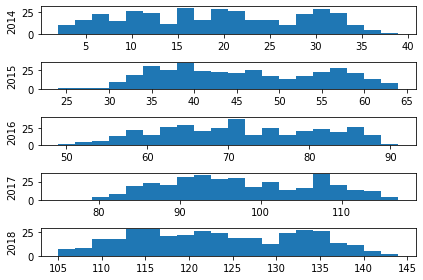

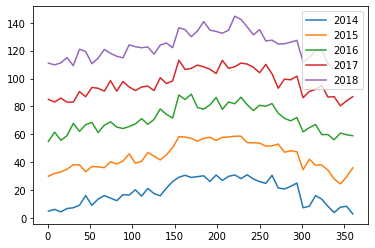

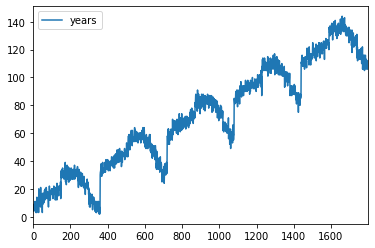

In [94]:
means= [5,10, 13,15,18, 28,29,30 ,25,20,10 , 4]
stds=[2,3,4,5,6]
trends = [k * 25 for k in range(len(stds))]
print("trends",trends)

years5 = gen_multi_dim_data(trends=trends, means= means,stds=stds,samples=30)

dff = convert_to_df(years5,["2014","2015","2016","2017","2018"])
df_to_hist(dff)
summarize_df_plots(dff)
df_flat = df_to_flat(dff,"years")
df_flat.plot()

In [0]:
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
import pandas as pd
 
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)	
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons,verbose):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=verbose, shuffle=False)
		model.reset_states()
	return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

Above code is standard code from documentation and internet(machinelearningmastery.com) . Below I convert them to utility methods. I want to test 2 things. Is it different to do walk-through on prediction or predict at once.

In [0]:
def pre_process(df,interval,lag,slice):
  raw = df.values
  diff_values = difference(raw, interval)
  supervised = timeseries_to_supervised(diff_values, lag)
  train, test = supervised.values[0:(-1 * slice) +1], supervised.values[-1 * slice:]
  return  scale(train, test)

def train_model(train_scaled,heat_up,verbose):
  lstm_model = fit_lstm(train_scaled, 1, 30, 4,verbose)
  # forecast the entire training dataset to build up state for forecasting
  if heat_up :
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)
  return lstm_model


def predict(model,raw_values,scaler,train_scaled,test_scaled):
  predictions = list()
  for i in range(len(test_scaled)):
    # make one-step forecast
	  X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	  yhat = forecast_lstm(model, 1, X)
	  # invert scaling
	  yhat = invert_scale(scaler, X, yhat)
	  # invert differencing
	  yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	  # store forecast
	  predictions.append(yhat)
	  expected = raw_values[len(train_scaled) + i ]
	  #print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

  len_actuals = -1 * len(test_scaled)
  # report performance
  rmse = sqrt(mean_squared_error(raw_values[len_actuals :], predictions))
  print('Test RMSE: %.3f' % rmse)
  # line plot of observed vs predicted
  pyplot.plot(raw_values[len_actuals:],label="actuals")
  pyplot.plot(predictions,label="predictions")
  pyplot.legend()
  pyplot.show()  

#batch predict predict at once the whole test set
def predict_batch(test_scaled2,train_scaled2,raw_values):
  X2, y2 = test_scaled2[:,0:-1],test_scaled2[:,1]

  X2 = X2.reshape( len(X2),1, 1)
  yhat = lstm_model.predict(X2,batch_size=1)

  df1 = pd.DataFrame()  
  df1["x"] = X2.reshape(X2.shape[0])
  df1["y"] = yhat
  new_row = df1.values
  
  array = numpy.array(new_row)
  array = array.reshape(len(array),2)
  inverted = scaler2.inverse_transform(array)
  
  begin = len(train_scaled2)
  calculated_diff = [raw_values[begin+index][0] + item[0] for index,item in enumerate(inverted) ]
  
  expected = raw_values[len(train_scaled2):]

  rmse = sqrt(mean_squared_error(expected, calculated_diff))
  print('Test RMSE: %.3f' % rmse)
  pyplot.plot(calculated_diff,label="predictions")
  pyplot.plot(expected,label="actuals")
  
  pyplot.legend()
  pyplot.show() 
    


Test RMSE: 4.032


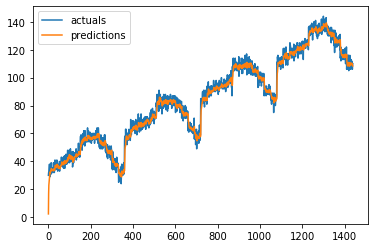

In [97]:
scaler2, train_scaled2, test_scaled2 = pre_process(df_flat,1,1,360 * 4)

lstm_model = train_model(train_scaled2,True,0)
raw_values = df_flat.values
predict(lstm_model,raw_values,scaler2,train_scaled2,test_scaled2)
#Below we can wee it is predicting nice 

Test RMSE: 4.745


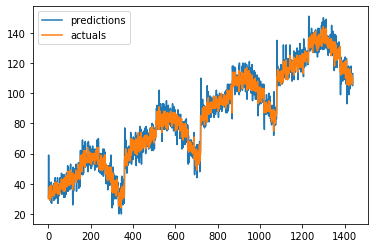

In [99]:
raw_values = df_flat.values
scaler2, train_scaled2, test_scaled2 = pre_process(df_flat,1,1,360 * 4)
lstm_model = train_model(train_scaled2,True,0)

predict_batch(test_scaled2,train_scaled2,df_flat.values)
#If we predict at once, it has bigger variations at year changes.
#Temperature trend is not smooth, it is discreete for all years. 

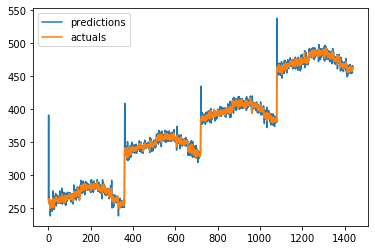